Imports

In [53]:
__author__ = "Artur Fejklowicz"

# Sources:
# - https://medium.com/@ashins1997/text-classification-dfe370bf7044
# - https://www.kaggle.com/code/shahkan/text-classification-using-logistic-regression
# - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn
# - https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from google.cloud import bigquery
import matplotlib.pyplot as plt
import nltk.stem.snowball
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords

Function to load polish stopwords from file

In [54]:

def load_lines_from_file(filename):
    """Loads newline-delimited strings from a file into a list."""
    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            lines = [line.strip() for line in lines]  # Remove trailing newlines
            return lines
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None


Retrive data from BigQuery

df.head()
                               description      Konto
0                         Top-Up by *4356     Others
1                                 Transak     Others
2                                  Amazon     Others
3                      Ihre Lieferadresse     Others
4           Cash at Os.pulku Lotniczego 1     Others
5              Refund from Amz*ksw Kingdo     Others
6                                  Google     Others
7                             Card Top-Up     Others
8              Google Pay Top-Up by *4356     Others
9                                  PayPal     Others
10                             AliExpress     Others
11                       Exchanged to PLN     Others
12                                Allegro     Others
13  Educational Team - Kindergarten No. 1     Others
14                      Cie Du Mont Blanc   PK Artur
15                           Maison Alpes   PK Artur
16                         Place du Poilu   PK Artur
17                     Casino Super

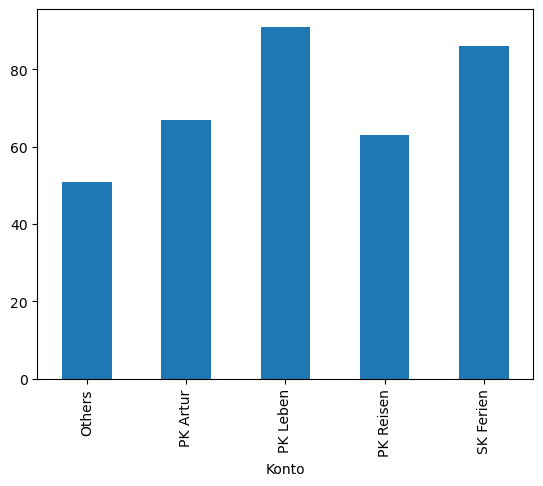

In [55]:
client = bigquery.Client(project="af-finanzen")
query = ("""SELECT
  description
  -- , Konto
  , CASE 
      WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
      ELSE Konto
    END as Konto
FROM banks.revolut_mapping_internal
""")
df = client.query(query).to_dataframe()  # API request
print(f"df.head()\n {df.head(25)}")
print(df.groupby("Konto").Konto.count())
df.groupby("Konto").Konto.count().plot.bar(ylim=0)
plt.show()


Rest to be nicely splited

final_features.shape:
(358, 612)
              precision    recall  f1-score   support

      Others       0.50      0.13      0.21        15
    PK Artur       0.67      0.10      0.17        20
    PK Leben       0.26      0.95      0.41        20
   PK Reisen       1.00      0.39      0.56        18
   SK Ferien       0.75      0.18      0.29        17

    accuracy                           0.37        90
   macro avg       0.64      0.35      0.33        90
weighted avg       0.63      0.37      0.33        90

Confusion Matrix: on training data
[[33  0  3  0  0]
 [ 0 47  0  0  0]
 [ 0  0 70  1  0]
 [ 0  0  1 44  0]
 [ 0  0  1  0 68]]


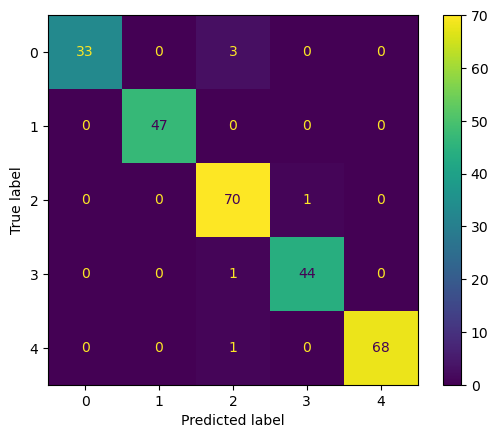

Confusion Matrix: on testing data
[[ 2  0 12  0  1]
 [ 2  2 16  0  0]
 [ 0  1 19  0  0]
 [ 0  0 11  7  0]
 [ 0  0 14  0  3]]


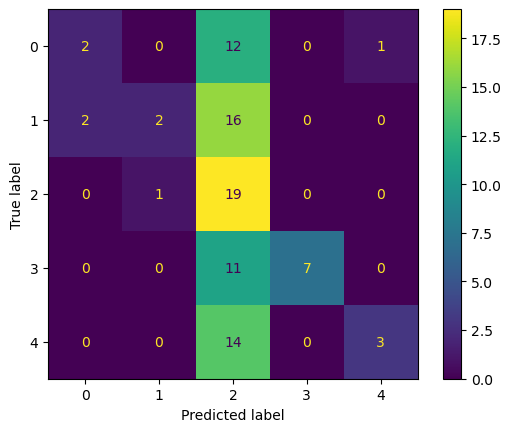

In [56]:

stops_eng = set(stopwords.words('english'))
stops_ger = set(stopwords.words('german'))
stops_ita = set(stopwords.words('italian'))
stops_spa = set(stopwords.words('spanish'))
stops_fra = set(stopwords.words('french'))
stops_pol = set(load_lines_from_file("../../python/logistic_regression_classification/polish.txt"))
stops = stops_eng.union(stops_ger).union(stops_ita).union(stops_spa).union(stops_fra)
if stops_pol:
    stops = stops.union(stops_pol)
stops = list(stops)

vectorizer = TfidfVectorizer(
    min_df=0.0001,
    stop_words=stops,
    max_features=5000,
    sublinear_tf=True, norm='l2', ngram_range=(1, 1))
final_features = vectorizer.fit_transform(df['description']).toarray()
print(f"final_features.shape:\n{final_features.shape}")
#np.set_printoptions(threshold=np.inf)
#print(f"final_featurese:\n{final_features}")
# print(f"vectorizer.get_feature_names_out() {vectorizer.get_feature_names_out()}")

X = df['description']
Y = df['Konto']
# print(f"Y {Y}")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k="all")),
                     ('clf',  LogisticRegression(multi_class='ovr', solver='liblinear', random_state=0))])


model = pipeline.fit(X_train, y_train)

ytest = np.array(y_test)

#c_names = pipeline.feature_names_in_
#print(f"c_names: {c_names}")
#print(f"get_feature_names_out: {model.feature_names_in_}")

# confusion matrix and classification report(precision, recall, F1-score)
classification_report = classification_report(ytest, model.predict(X_test))
confusion_matrix_training = confusion_matrix(np.array(y_train), model.predict(X_train))
confusion_matrix_testing = confusion_matrix(ytest, model.predict(X_test))

print(classification_report)

print("Confusion Matrix: on training data")
print(confusion_matrix_training)
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training, display_labels=n_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training)
disp.plot()
plt.show()

print("Confusion Matrix: on testing data")
print(confusion_matrix_testing)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing)
disp.plot()
plt.show()